In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import zipfile
import io
from datetime import datetime, timedelta


In [4]:
SYMBOL = "NIFTY"
INSTRUMENT = "OPTIDX"

WING_WIDTH = 200        # Iron Fly wings (points)
TARGET_PCT = 0.70       # Exit at 70% of max profit
STOPLOSS_PCT = 0.40     # Exit at 40% of max loss


In [6]:
def load_fo_bhavcopy(date):
    date_str = date.strftime("%d%b%Y").upper()
    url = (
        f"https://archives.nseindia.com/content/historical/DERIVATIVES/"
        f"{date.year}/{date.strftime('%b').upper()}/fo{date_str}bhav.csv.zip"
    )

    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers)

    if r.status_code != 200:
        return None

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        csv_name = [f for f in z.namelist() if f.endswith(".csv")][0]
        with z.open(csv_name) as f:
            return pd.read_csv(f)


In [8]:
start_date = datetime(2023, 1, 2)
end_date   = datetime(2023, 6, 30)

dfs = []
d = start_date

while d <= end_date:
    day_df = load_fo_bhavcopy(d)
    if day_df is not None:
        dfs.append(day_df)
    d += timedelta(days=1)

raw_df = pd.concat(dfs, ignore_index=True)
raw_df.head()


,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP,Unnamed: 15
0,FUTIDX,BANKNIFTY,25-Jan-2023,0.0,XX,43248.10,43535.00,43136.05,43393.80,43393.80,117235.0,1271310.65,2189100.0,18850.0,02-JAN-2023,NaN
1,FUTIDX,BANKNIFTY,23-Feb-2023,0.0,XX,43016.35,43688.00,43016.30,43564.15,43564.15,4746.0,51653.34,179650.0,12075.0,02-JAN-2023,NaN
2,FUTIDX,BANKNIFTY,29-Mar-2023,0.0,XX,43586.60,43853.60,43500.00,43739.60,43739.60,986.0,10774.11,10725.0,4350.0,02-JAN-2023,NaN
3,FUTIDX,FINNIFTY,31-Jan-2023,0.0,XX,19097.05,19194.50,19029.90,19168.85,19168.85,507.0,3880.30,11880.0,-680.0,02-JAN-2023,NaN
4,FUTIDX,FINNIFTY,28-Feb-2023,0.0,XX,18867.40,19223.15,18867.40,19223.15,19223.15,3.0,22.87,80.0,-40.0,02-JAN-2023,NaN


In [10]:
df = raw_df[
    (raw_df["SYMBOL"] == SYMBOL) &
    (raw_df["INSTRUMENT"] == INSTRUMENT)
].copy()

# Correct handling of mixed date formats
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format="mixed", dayfirst=True)
df["EXPIRY_DT"] = pd.to_datetime(df["EXPIRY_DT"], format="mixed", dayfirst=True)

df["STRIKE_PR"] = df["STRIKE_PR"].astype(float)

# Mandatory liquidity & sanity filters
df = df[
    (df["CONTRACTS"] > 0) &
    (df["OPEN_INT"] > 0) &
    (df["CLOSE"] > 0)
]

# Drop junk columns
df = df.drop(columns=[c for c in df.columns if "Unnamed" in c])

df = df.sort_values(["TIMESTAMP", "EXPIRY_DT", "STRIKE_PR"])
df.head()


,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP
4334,OPTIDX,NIFTY,2023-01-05,15050.0,PE,0.60,0.60,0.30,0.35,0.35,7446.0,56032.85,142750.0,-51850.0,2023-01-02
4335,OPTIDX,NIFTY,2023-01-05,15100.0,PE,0.50,0.60,0.30,0.40,0.40,3458.0,26108.72,53100.0,-11450.0,2023-01-02
4336,OPTIDX,NIFTY,2023-01-05,15150.0,PE,0.60,0.60,0.30,0.45,0.45,1786.0,13529.40,14150.0,1950.0,2023-01-02
4337,OPTIDX,NIFTY,2023-01-05,15200.0,PE,0.65,0.65,0.30,0.45,0.45,545.0,4142.12,8050.0,4000.0,2023-01-02
4338,OPTIDX,NIFTY,2023-01-05,15250.0,PE,0.60,0.65,0.35,0.40,0.40,486.0,3705.87,6800.0,1950.0,2023-01-02


In [12]:
df["weekday"] = df["TIMESTAMP"].dt.weekday  # Monday = 0
mondays = sorted(df[df["weekday"] == 0]["TIMESTAMP"].unique())

print("Total Mondays:", len(mondays))
mondays[:5]


Total Mondays: 25


[Timestamp('2023-01-02 00:00:00'),
 Timestamp('2023-01-09 00:00:00'),
 Timestamp('2023-01-16 00:00:00'),
 Timestamp('2023-01-23 00:00:00'),
 Timestamp('2023-01-30 00:00:00')]

In [14]:
def find_atm(chain):
    ce = chain[chain["OPTION_TYP"] == "CE"][["STRIKE_PR", "CLOSE"]]
    pe = chain[chain["OPTION_TYP"] == "PE"][["STRIKE_PR", "CLOSE"]]

    merged = ce.merge(pe, on="STRIKE_PR", suffixes=("_CE", "_PE"))
    merged["diff"] = abs(merged["CLOSE_CE"] - merged["CLOSE_PE"])

    return merged.sort_values("diff").iloc[0]["STRIKE_PR"]


In [16]:
def get_price(data, date, expiry, strike, opt_type):
    row = data[
        (data["TIMESTAMP"] == date) &
        (data["EXPIRY_DT"] == expiry) &
        (data["STRIKE_PR"] == strike) &
        (data["OPTION_TYP"] == opt_type)
    ]
    if row.empty:
        return None
    return float(row["CLOSE"].iloc[0])


In [18]:
def construct_iron_fly(data, trade_date):
    day = data[data["TIMESTAMP"] == trade_date]
    expiry = day["EXPIRY_DT"].min()

    chain = day[day["EXPIRY_DT"] == expiry]
    if chain.empty:
        return None

    atm = find_atm(chain)

    legs = {
        "sell_ce": get_price(data, trade_date, expiry, atm, "CE"),
        "sell_pe": get_price(data, trade_date, expiry, atm, "PE"),
        "buy_ce":  get_price(data, trade_date, expiry, atm + WING_WIDTH, "CE"),
        "buy_pe":  get_price(data, trade_date, expiry, atm - WING_WIDTH, "PE"),
    }

    if any(v is None for v in legs.values()):
        return None

    return {"expiry": expiry, "atm": atm, "entry": legs}


In [20]:
def compute_pnl(entry, current):
    return (
        (entry["sell_ce"] - current["sell_ce"]) +
        (entry["sell_pe"] - current["sell_pe"]) -
        (current["buy_ce"] - entry["buy_ce"]) -
        (current["buy_pe"] - entry["buy_pe"])
    )


In [22]:
trades = []

for monday in mondays:
    trade = construct_iron_fly(df, monday)
    if trade is None:
        continue

    entry = trade["entry"]
    expiry = trade["expiry"]

    max_profit = sum(entry.values())
    max_loss = WING_WIDTH - max_profit

    days = sorted(
        df[
            (df["TIMESTAMP"] >= monday) &
            (df["TIMESTAMP"] <= expiry)
        ]["TIMESTAMP"].unique()
    )

    exited = False

    for d in days:
        curr = {
            "sell_ce": get_price(df, d, expiry, trade["atm"], "CE"),
            "sell_pe": get_price(df, d, expiry, trade["atm"], "PE"),
            "buy_ce":  get_price(df, d, expiry, trade["atm"] + WING_WIDTH, "CE"),
            "buy_pe":  get_price(df, d, expiry, trade["atm"] - WING_WIDTH, "PE"),
        }

        if any(v is None for v in curr.values()):
            continue

        pnl = compute_pnl(entry, curr)

        if pnl >= TARGET_PCT * max_profit:
            trades.append((monday, d, pnl, "Target"))
            exited = True
            break

        if pnl <= -STOPLOSS_PCT * max_loss:
            trades.append((monday, d, pnl, "Stoploss"))
            exited = True
            break

    if not exited:
        trades.append((monday, expiry, pnl, "Time Exit"))


In [24]:
results = pd.DataFrame(
    trades, columns=["EntryDate", "ExitDate", "PnL", "ExitReason"]
)

results["HoldingDays"] = (results["ExitDate"] - results["EntryDate"]).dt.days

equity = results["PnL"].cumsum()

print("Total trades:", len(results))
print("Total PnL:", round(equity.iloc[-1], 2))
print("Win rate:", round((results["PnL"] > 0).mean() * 100, 2), "%")
print("Max drawdown:", round((equity.cummax() - equity).max(), 2))

results.head()


Total trades: 25
Total PnL: 532.55
Win rate: 36.0 %
Max drawdown: 210.15


,EntryDate,ExitDate,PnL,ExitReason,HoldingDays
0,2023-01-02,2023-01-02,0.0,Stoploss,0
1,2023-01-09,2023-01-09,0.0,Stoploss,0
2,2023-01-16,2023-01-16,0.0,Stoploss,0
3,2023-01-23,2023-01-25,-178.9,Stoploss,2
4,2023-01-30,2023-01-30,0.0,Stoploss,0


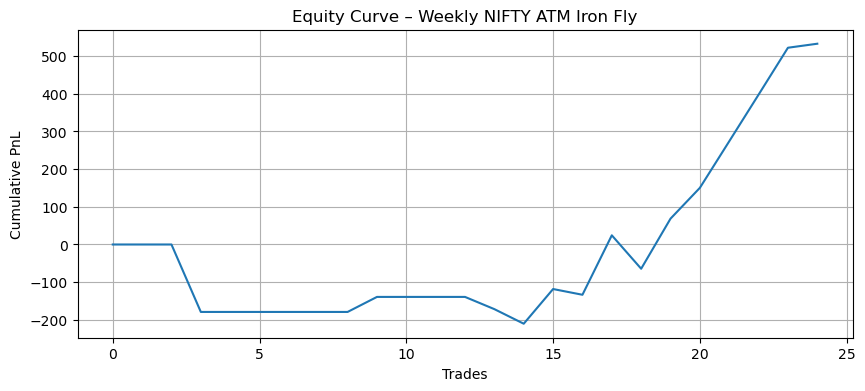

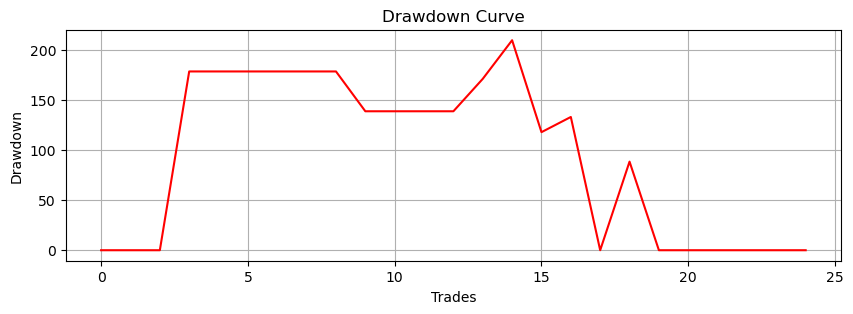

In [26]:
plt.figure(figsize=(10,4))
plt.plot(equity)
plt.title("Equity Curve – Weekly NIFTY ATM Iron Fly")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(equity.cummax() - equity, color="red")
plt.title("Drawdown Curve")
plt.xlabel("Trades")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


In [28]:
import os

FIG_DIR = "report_figures"
os.makedirs(FIG_DIR, exist_ok=True)

FIG_DIR


'report_figures'

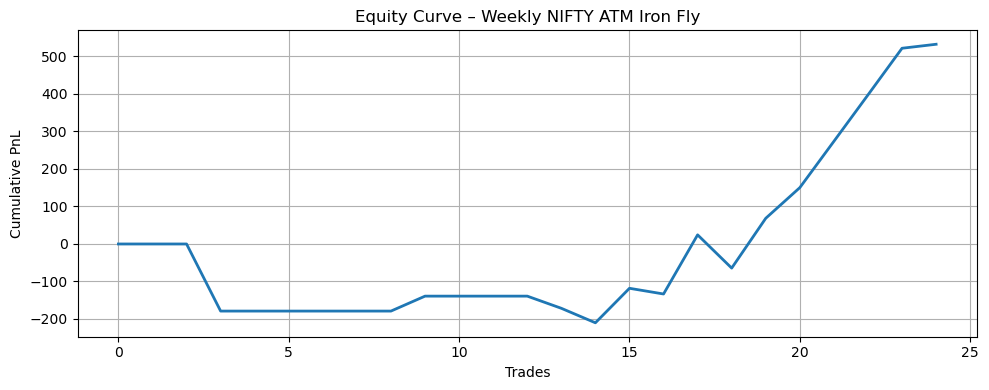

In [30]:
plt.figure(figsize=(10,4))
plt.plot(equity, linewidth=2)
plt.title("Equity Curve – Weekly NIFTY ATM Iron Fly")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/equity_curve.png", dpi=300)
plt.show()


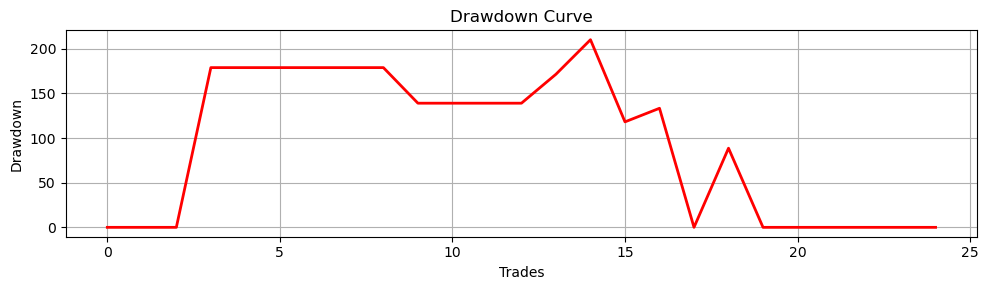

In [32]:
drawdown = equity.cummax() - equity

plt.figure(figsize=(10,3))
plt.plot(drawdown, color="red", linewidth=2)
plt.title("Drawdown Curve")
plt.xlabel("Trades")
plt.ylabel("Drawdown")
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/drawdown_curve.png", dpi=300)
plt.show()
